### Imports

In [3]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
import scipy.stats as sps
from scipy.interpolate import interp1d

### Constants

In [4]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7
%config InlineBackend.figure_format = 'retina'

### Functions

In [5]:
from IPython.core.debugger import set_trace

def prepare_cases(cases, min_cases=25, win_size=7):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(
        win_size,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    idx_start = np.searchsorted(smoothed, min_cases)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [6]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

### Get Confidence Intervals

In [7]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

In [111]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_75'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_75'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

### Get County Data from Github

In [1]:
import io
import requests

In [4]:
url="https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
s=requests.get(url).content
county_df = (pd
             .read_csv(io.StringIO(s.decode('utf-8')))
             .assign(
                 date = lambda d: pd.to_datetime(d.date),
             )
            )

#### Notes on County and Population Data

1. New York City has been entered as a single "county" without a FIPS code. We are assigning it the dummy code of 9999 and treating it as a county rather than try to split it into five parts with actual FIPS codes.

2. It appears that Rhode Island was only tracking cases at the state level until March 24 when it began to track _some_ cases at the county level. However, even after March 24 most of Rhode Islands cases are from an "Unknown" county. For now we will treat Rhode Island as a single county with a dummy FIPS code of 9998.

3. Most other states have the same problem as Rhode Island to varying degrees. They have cases in a county called "Unknown" initially and then as time goes on the start collecting county-level data but some cases are still "Unknown". For now we will just drop any counties that don't have a FIPS code after applying dummy fips codes.

In [5]:
# Add Population data to each county
url="https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
s=requests.get(url).content
NEW_YORK_CITY_DUMMY_FIPS = 9999
NEW_YORK_CITY_2019_POPULATION = 8399000
RHODE_ISLAND_DUMMY_FIPS = 9998
RHODE_ISLAND_2019_POPULATION = 1059000

county_df_raw = pd.read_csv(io.StringIO(s.decode('utf-8')))
county_df = county_df_raw.copy()
# Assign dummy FIPS
county_df.loc[county_df.state == "Rhode Island", "fips"] = RHODE_ISLAND_DUMMY_FIPS
county_df.loc[county_df.county == "New York City", "fips"] = NEW_YORK_CITY_DUMMY_FIPS
# drop rows that don't have a FIPS value
# these are all the rows where the county is "Unknown" except for Rhode Island and New York City
county_df = (county_df[['date', 'county', 'state', 'fips', 'cases']]
             .dropna(subset=["fips"])
             .assign(
                 date = lambda d: pd.to_datetime(d.date),
                 fips = lambda d: d.fips.astype('int'),
             )
            )
# Combine Rhode Island counties into single county
rh_agg_df = (county_df
             .loc[county_df.state == "Rhode Island"]
             .groupby("date")
             .agg({
                 'county': lambda d: 'Rhode Island',
                 'state': lambda d: 'Rhode Island',
                 'fips': 'max',
                 'cases': 'sum',
             })
             .reset_index()
            )
# Remove old Rhode Island rows and append the new aggregated rows
old_rh_rows = county_df.loc[county_df.state == "Rhode Island"]
county_df = (county_df
             .drop(old_rh_rows.index)
             .append(rh_agg_df)
            )

# Add Populations from Jason's Script
pop_df_raw = pd.read_csv("./data/county_populations.csv")
pop_df = (pop_df_raw
     .dropna()
     .assign(fips=lambda d: d.fips.astype('int'))
     [['fips', 'pop_est2019']]
)
county_df = county_df.merge(pop_df, on="fips", how="left")
# Fill in the populations of New York City and Rhode Island since they are not in the county-level population data.
county_df.loc[county_df.county == "New York City", 'pop_est2019'] = NEW_YORK_CITY_2019_POPULATION
county_df.loc[county_df.county == "Rhode Island", 'pop_est2019'] = RHODE_ISLAND_2019_POPULATION
# Convert data to the series format closer to the format that the Rt calculations expect
county_cases = (county_df
             .set_index(["county", "date"])
             .drop(columns=["fips", "state"])
             .rename(columns={'pop_est2019': 'population'})
             .sort_index()
             .squeeze()
            )

In [58]:
import re

counties = sorted(list(set([county for county, date in county_cases.index])))

def get_county_like(search_string):
    """Search for county name using regex."""
    pattern = re.compile(search_string, re.I)
    return [county for county in counties if pattern.search(county)]

def get_county_cases(county_name):
    """Get rows where county name matches `county_name`."""
    return county_cases.xs(county_name)

def county_to_admissions(county_cases, hosp_rate=0.025, market_share=0.15):
    """
    Calculated expected admissions for hospital in county with the assuming
    the respective hospitalization rates and market_share.
    """
    return np.floor(county_cases * hosp_rate * market_share)

In [136]:
get_county_like("bronx")

[]

### Get $R_t$ for Each Day of Actuals

In [108]:
def display_counties(counties, convert_to_admits=False, **kwargs):
    if type(counties) is not list:
        counties = [counties]
    fig, axes = plt.subplots(nrows=len(counties), ncols=2, figsize=(1200/72,(400 * len(counties))/72))
    fig.set_facecolor('w')
    for county_name, axes in zip(counties, axes):
        cases = get_county_cases(county_name)
        if convert_to_admits:
            cases = county_to_admissions(cases, **kwargs)
        cases_prepped, smoothed = prepare_cases(cases, min_cases=5)

        # Get cases plot
        
        ax = axes[0]
        ax.plot(
            cases_prepped.index, 
            cases_prepped.values, 
            c='k',
            linestyle=':',
            alpha=.5,
            label='Actual',
        )
        ax.set_title(f"Cases per Day ({county_name})")
            
        ax.plot(smoothed.index, 
                smoothed.values,
                label='Smoothed',
                )
        
        ax.legend()

        
        # Get R_t plot
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

        # Confidence Intervals
        # Note that this takes a while to execute - it's not the most efficient algorithm
        hdis = highest_density_interval(posteriors, p=.75)

        most_likely = posteriors.idxmax().rename('ML')

        # Look into why you shift -1
        result = pd.concat([most_likely, hdis], axis=1)

        # Plot R_t with intervals
        ax = axes[1]

        plot_rt(result, ax, county_name)
        ax.set_title(f'Real-time $R_t$ for {county_name}')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [109]:
get_county_like("new y")

['New York City']

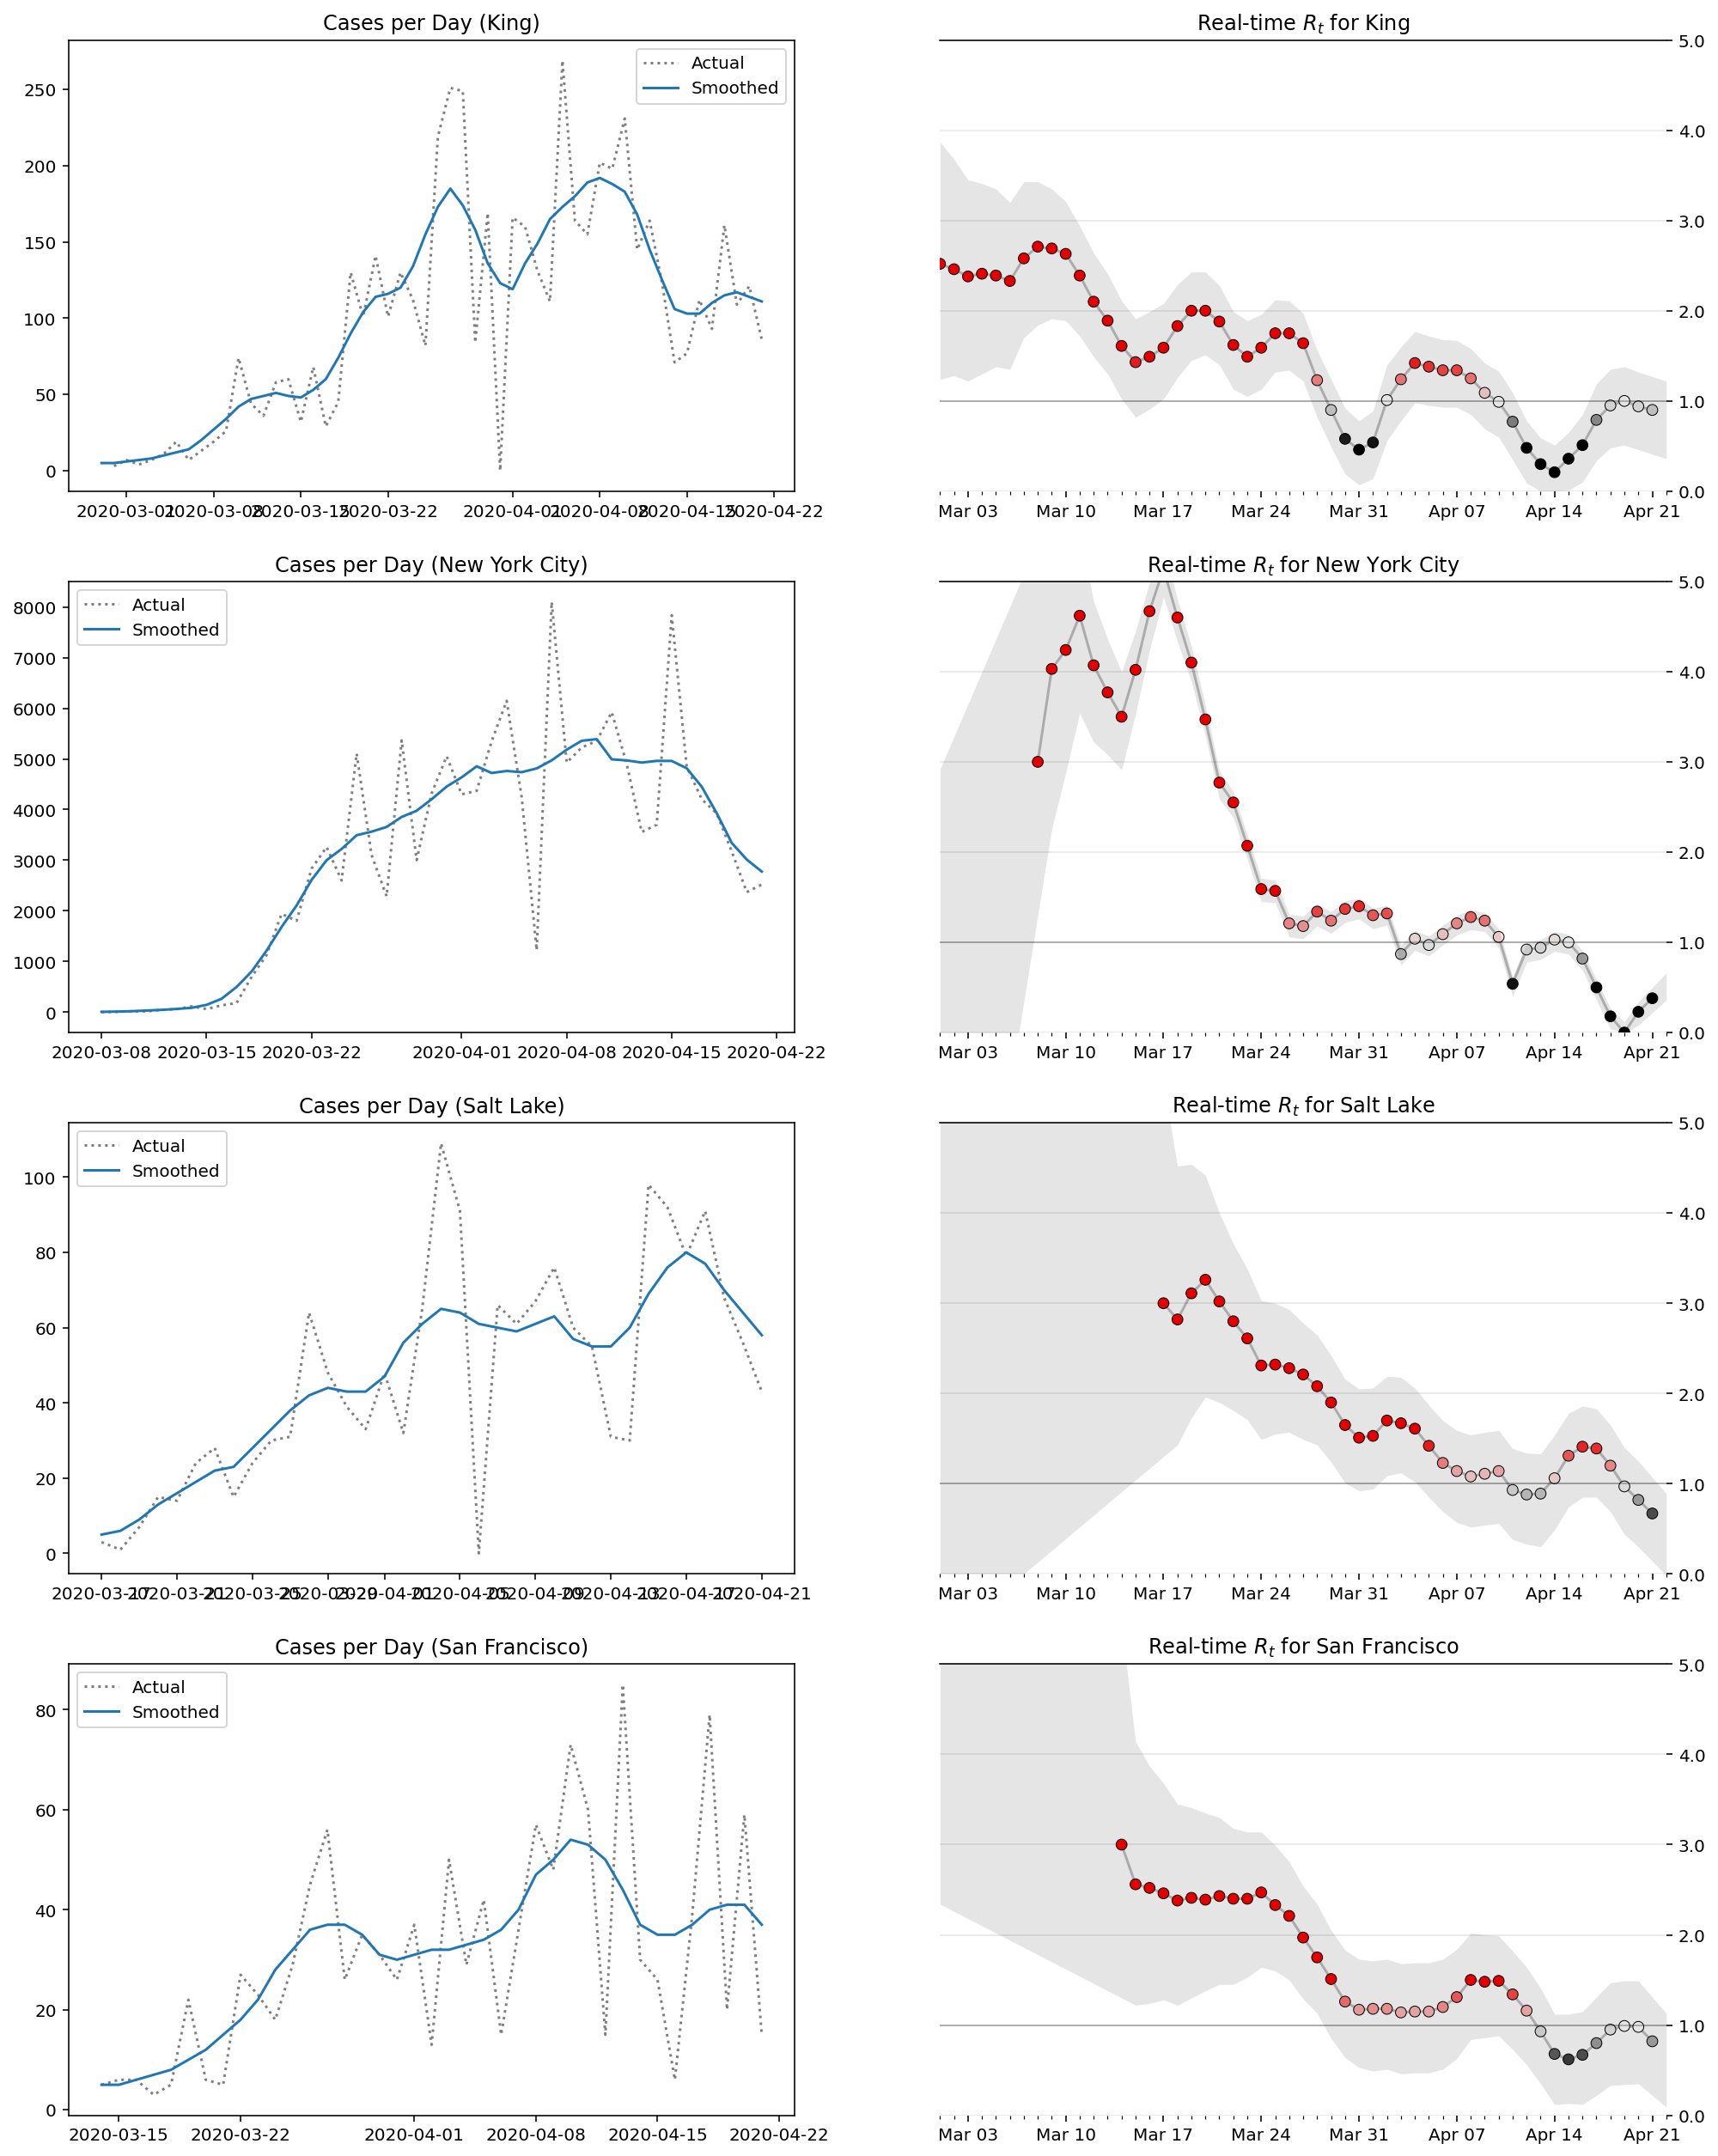

In [115]:
counties = ["King", "New York City", "Salt Lake", "San Francisco"]
display_counties(counties)

### Add $R_t$ for a Single County

In [157]:
def add_Rt_county(county_name, convert_to_admits=False, **kwargs):
    cases = get_county_cases(county_name)
    if convert_to_admits:
        cases = county_to_admissions(cases, **kwargs)
    cases_prepped, smoothed = prepare_cases(cases, min_cases=5)

    # Get R_t plot
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

    # Confidence Intervals
    # Note that this takes a while to execute - it's not the most efficient algorithm
    hdis = highest_density_interval(posteriors, p=.75)

    most_likely = posteriors.idxmax().rename('ML')

    # Look into why you shift -1
    result = pd.concat([most_likely, hdis], axis=1)
    result["cases"] = cases_prepped
    result["smoothed"] = smoothed
    result["date"] = result.index
    
    # fill 0.0 values of ML with 0.01
    result.ML = result.ML.where(result.ML > 0.01, 0.01)
    
    return(result)

In [180]:
county = ["King"]
county = ["Los Angeles"]
county_df = add_Rt_county(county)
county_df["date_str"] = county_df.date.astype(str)
county_df.head()

,ML,Low_75,High_75,cases,smoothed,date,date_str
date,,,,,,,
2020-03-11,3.00,1.30,5.44,8.0,5.0,2020-03-11,2020-03-11
2020-03-12,3.12,1.60,4.87,4.0,7.0,2020-03-12,2020-03-12
2020-03-13,3.25,1.83,4.63,8.0,10.0,2020-03-13,2020-03-13
2020-03-14,3.45,2.19,4.60,13.0,15.0,2020-03-14,2020-03-14
2020-03-15,3.53,2.44,4.47,16.0,22.0,2020-03-15,2020-03-15


In [181]:
def forecast_Rt(county_df):
    cases = get_county_cases(county_name)
    return(result)

In [63]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [73]:
# Import forecasting function
ro.r('''
       source('forecast_Rt.R')
''')
r_fncFcstRT = ro.globalenv['.fncFcstRT']

In [57]:
# Load splines and forecast
splines = importr('splines')
forecast = importr("forecast")

In [182]:
# Get forecast
county = ["Los Angeles"]
county_df = add_Rt_county(county)
county_df["date_str"] = county_df.date.astype(str)

with localconverter(ro.default_converter + pandas2ri.converter):
    r_county_df = ro.conversion.py2rpy(county_df)   
# Do stuff with r_df
results_r_df = r_fncFcstRT(r_county_df, "date_str", "ML", "smoothed")
with localconverter(ro.default_converter + pandas2ri.converter):
    county_df = ro.conversion.rpy2py(results_r_df)
county_df.date = county_df.date_str.astype(np.datetime64)
county_df.index = county_df.date
county_df

,date_str,ML,Low_75,High_75,cases,smoothed,date,fcst,prd_lin,prd_spln,prd_ets,prd_loess
date,,,,,,,,,,,,
2020-03-11,2020-03-11,3.00,1.30,5.44,8.0,5.0,2020-03-11,0.0,3.014208,11.006662,NaN,4.350452
2020-03-12,2020-03-12,3.12,1.60,4.87,4.0,7.0,2020-03-12,0.0,2.962407,7.294294,NaN,4.153760
2020-03-13,2020-03-13,3.25,1.83,4.63,8.0,10.0,2020-03-13,0.0,2.910606,5.680506,NaN,3.963368
2020-03-14,2020-03-14,3.45,2.19,4.60,13.0,15.0,2020-03-14,0.0,2.858805,4.729762,NaN,3.779214
2020-03-15,2020-03-15,3.53,2.44,4.47,16.0,22.0,2020-03-15,0.0,2.807004,4.086524,3.511490,3.601236
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,2020-05-17,NaN,NaN,NaN,NaN,NaN,2020-05-17,1.0,-0.005814,0.953841,1.951458,8.777475
2020-05-18,2020-05-18,NaN,NaN,NaN,NaN,NaN,2020-05-18,1.0,0.004284,0.947610,1.951423,9.173138
2020-05-19,2020-05-19,NaN,NaN,NaN,NaN,NaN,2020-05-19,1.0,0.016077,0.941489,1.951394,9.578239


In [124]:
def plot_rt_fc(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # fut = result.loc[result.ML.isnull()].copy() # Shows only future dates
    fut = result.copy()
    fc_values = fut['prd_spln']
    fc_index = fut['ML'].index.get_level_values('date')
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.plot(fc_index, fc_values, c='b', zorder=1)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_75'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_75'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

<ipython-input-124-a529f8053041>:13: RuntimeWarning: invalid value encountered in subtract
  color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


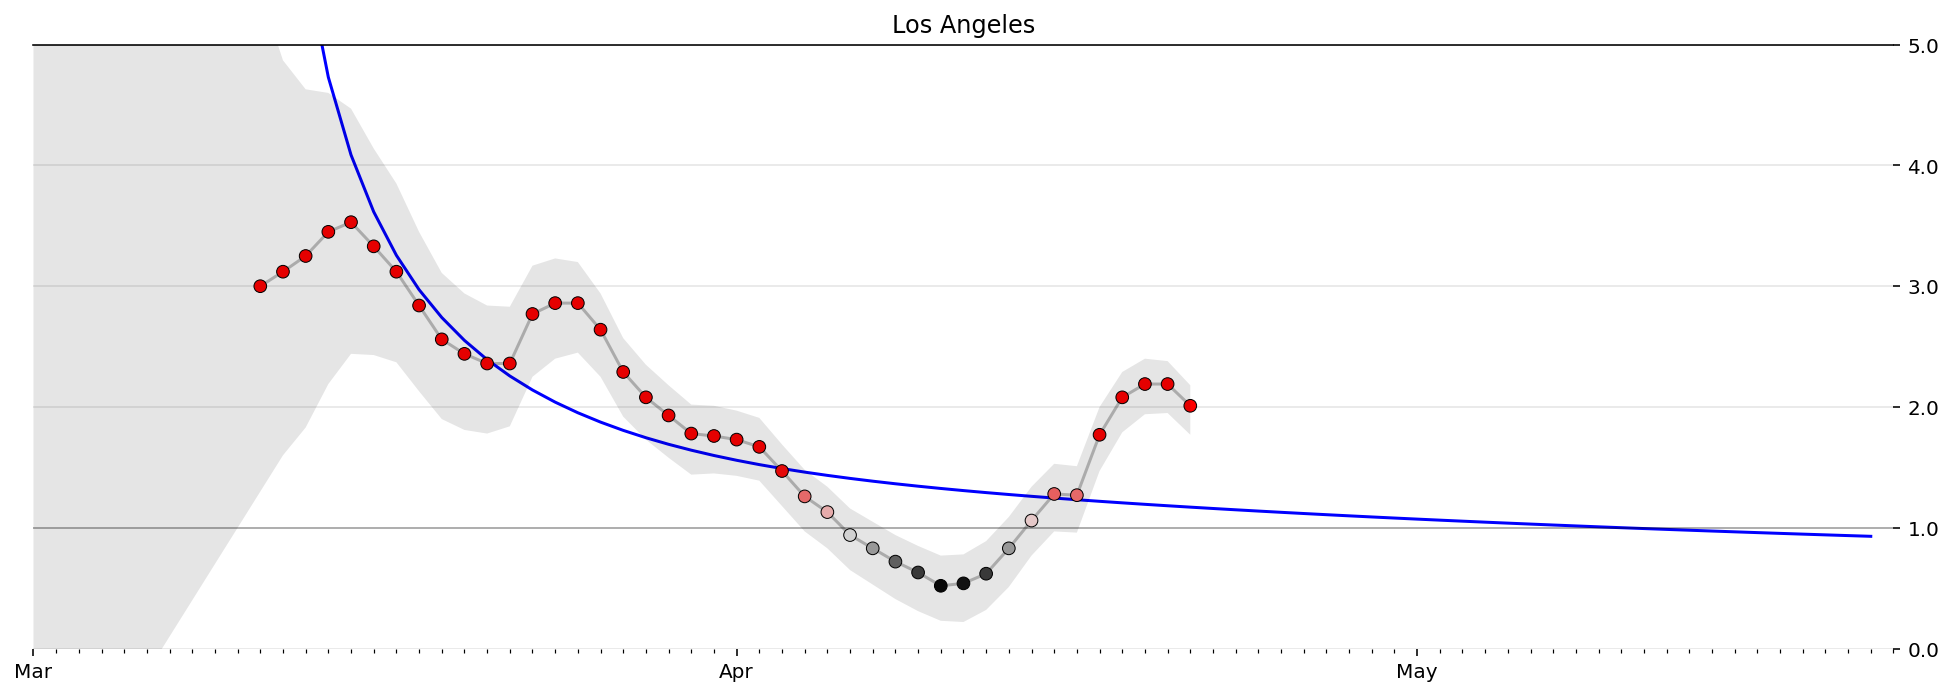

In [183]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1200/72,400/72))
fig.set_facecolor('w')

plot_rt_fc(county_df, axes, "Los Angeles")

# Run SIR model

Try earliest actual as number of infections for seed row
* I = confirmed cases
* S = pop - I
* R = 0

Run dynamic $R_t$ model

In [169]:
county_df.tail()

,date_str,ML,Low_75,High_75,cases,smoothed,date,fcst,prd_lin,prd_spln,prd_ets,prd_loess
date,,,,,,,,,,,,
2020-05-17,2020-05-17,NaN,NaN,NaN,NaN,NaN,2020-05-17,1.0,0.01,0.006366,0.005110,3.197276
2020-05-18,2020-05-18,NaN,NaN,NaN,NaN,NaN,2020-05-18,1.0,0.01,0.008956,0.009162,3.374607
2020-05-19,2020-05-19,NaN,NaN,NaN,NaN,NaN,2020-05-19,1.0,0.01,0.011916,0.013700,3.557858
2020-05-20,2020-05-20,NaN,NaN,NaN,NaN,NaN,2020-05-20,1.0,0.01,0.015123,0.018560,3.747039
2020-05-21,2020-05-21,NaN,NaN,NaN,NaN,NaN,2020-05-21,1.0,0.01,0.018453,0.023581,3.942162


In [257]:
def sir_rt(actuals_fc, regional_population, infectious_days):
    last_val = sir_df.ML.last_valid_index()
    d = actuals_fc.loc[last_val:].copy()
    N = d.shape[0]
    
    i_n = d.cases.iloc[0] # Last actual value
    s_n = regional_population - i_n
    r_n = 0.
    gamma = 1 / infectious_days
    
    # Based on actuals
    beta_n = d.ML.iloc[0] * gamma / s_n
    
    s_a, i_a, r_a, beta_a = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    for index in range(N):
        s_a[index] = s_n
        i_a[index] = i_n
        r_a[index] = r_n
        beta_a[index] = beta_n
    
        s = s_n
        i = i_n
        r = r_n
        beta = beta_n
        
        s_n = (-beta * s * i) + s
        i_n = (beta * s * i - gamma * i) + i
        r_n = gamma * i + r
        
        
        # Update beta with actual Rt for past values, forecasted beta for future values.
        if d.fcst.iloc[index] == 0:
            beta_n = d.ML.iloc[index] * gamma / s
        elif d.fcst.iloc[index] == 1:
            beta_n = d.prd_spln.iloc[index] * gamma / s
        else: 
            beta_n = -1
    
    # create output
    actuals_fc["s"] = np.nan
    actuals_fc["i"] = np.nan
    actuals_fc["r"] = np.nan
    actuals_fc["b"] = np.nan
    
    actuals_fc["s"].loc[last_val:] = s_a
    actuals_fc["i"].loc[last_val:] = i_a
    actuals_fc["r"].loc[last_val:] = r_a
    actuals_fc["b"].loc[last_val:] = beta_a
        
    return actuals_fc

In [258]:
sir_df = sir_rt(county_df, 13000000, 14)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,date_str,ML,Low_75,High_75,cases,smoothed,date,fcst,prd_lin,prd_spln,prd_ets,prd_loess,s,i,r,b
date,,,,,,,,,,,,,,,,
2020-04-15,2020-04-15,1.28,0.97,1.53,449.0,452.0,2020-04-15,0.0,1.201171,1.246220,1.150319,1.337433,NaN,NaN,NaN,NaN
2020-04-16,2020-04-16,1.27,0.96,1.51,358.0,469.0,2020-04-16,0.0,1.149370,1.232488,1.385749,1.409190,NaN,NaN,NaN,NaN
2020-04-17,2020-04-17,1.77,1.47,2.00,537.0,553.0,2020-04-17,0.0,1.097569,1.219305,1.324727,1.491588,NaN,NaN,NaN,NaN
2020-04-18,2020-04-18,2.08,1.79,2.29,630.0,664.0,2020-04-18,0.0,1.045768,1.206618,1.928728,1.584668,NaN,NaN,NaN,NaN
2020-04-19,2020-04-19,2.19,1.94,2.40,320.0,795.0,2020-04-19,0.0,0.993967,1.194375,2.246072,1.688461,NaN,NaN,NaN,NaN
2020-04-20,2020-04-20,2.19,1.95,2.38,1475.0,942.0,2020-04-20,0.0,0.942165,1.182533,2.308393,1.802977,NaN,NaN,NaN,NaN
2020-04-21,2020-04-21,2.01,1.77,2.18,1324.0,1075.0,2020-04-21,0.0,0.904545,1.171054,2.254145,1.928204,1.299868e+07,1324.000000,0.000000,1.104508e-08
2020-04-22,2020-04-22,NaN,NaN,NaN,NaN,NaN,2020-04-22,1.0,0.847749,1.159907,1.998276,2.064105,1.299849e+07,1419.517143,94.571429,1.104508e-08
2020-04-23,2020-04-23,NaN,NaN,NaN,NaN,NaN,2020-04-23,1.0,0.791091,1.149070,1.988877,2.210632,1.299828e+07,1521.922185,195.965510,6.373856e-09


In [274]:
def plot_actuals_sir(sir_df, county):
    DATE_FORMAT = "%b %d"
    y_scale = alt.Scale(
        domain = (0, 40),
        clamp = True,
    )
    x = dict(shorthand="date:T", title="Date", axis=alt.Axis(format=(DATE_FORMAT)))
    y = dict(shorthand="value:Q", title="People", scale=y_scale)

    p1 = (
        alt.Chart(data=sir_df, title=county)
       .transform_fold(['i', 'r'])
       .encode(x='date:T', y="value:Q", color='key:N')
       .mark_line()
    )

    y = alt.Y("value:Q", scale = alt.Scale(domain=(0, 1000)), color='key:N')

    p2 = (
        alt.Chart(data=sir_df, title=county)
        .transform_fold(['cases', "smoothed"])
        .encode(x='date:T', y="value:Q", color='key:N')
        .mark_line(point = True, clip=True)
    )

    charts = [p1, p2]
    return(alt.layer(*charts, data=sir_df))

plot_actuals_sir(sir_df, "LA")


alt.LayerChart(...)

# Single function for everything

In [260]:
get_county_like("new y")

['New York City']

In [264]:
county = ["Los Angeles"]

def county_sir(county, population):
    df = add_Rt_county(county)
    df["date_str"] = df.date.astype(str)

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(df)   
    # Do stuff with r_df
    results_r_df = r_fncFcstRT(r_df, "date_str", "ML", "smoothed")
    with localconverter(ro.default_converter + pandas2ri.converter):
        df = ro.conversion.rpy2py(results_r_df)
    df.date = df.date_str.astype(np.datetime64)
    df.index = df.date
    
    
    df = sir_rt(df, population, 14)
    return(df)


sir_df = county_sir(county, 13000000)
sir_df

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,date_str,ML,Low_75,High_75,cases,smoothed,date,fcst,prd_lin,prd_spln,prd_ets,prd_loess,s,i,r,b
date,,,,,,,,,,,,,,,,
2020-03-11,2020-03-11,3.00,1.30,5.44,8.0,5.0,2020-03-11,0.0,3.014208,11.006662,NaN,4.350452,NaN,NaN,NaN,NaN
2020-03-12,2020-03-12,3.12,1.60,4.87,4.0,7.0,2020-03-12,0.0,2.962407,7.294294,NaN,4.153760,NaN,NaN,NaN,NaN
2020-03-13,2020-03-13,3.25,1.83,4.63,8.0,10.0,2020-03-13,0.0,2.910606,5.680506,NaN,3.963368,NaN,NaN,NaN,NaN
2020-03-14,2020-03-14,3.45,2.19,4.60,13.0,15.0,2020-03-14,0.0,2.858805,4.729762,NaN,3.779214,NaN,NaN,NaN,NaN
2020-03-15,2020-03-15,3.53,2.44,4.47,16.0,22.0,2020-03-15,0.0,2.807004,4.086524,3.511490,3.601236,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,2020-05-17,NaN,NaN,NaN,NaN,NaN,2020-05-17,1.0,-0.005814,0.953841,1.951458,8.777475,1.299532e+07,1672.454118,3005.665578,5.277587e-09
2020-05-18,2020-05-18,NaN,NaN,NaN,NaN,NaN,2020-05-18,1.0,0.004284,0.947610,1.951423,9.173138,1.299521e+07,1667.696595,3125.126586,5.242769e-09
2020-05-19,2020-05-19,NaN,NaN,NaN,NaN,NaN,2020-05-19,1.0,0.016077,0.941489,1.951394,9.578239,1.299509e+07,1662.197021,3244.247771,5.208569e-09


<ipython-input-124-a529f8053041>:13: RuntimeWarning: invalid value encountered in subtract
  color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


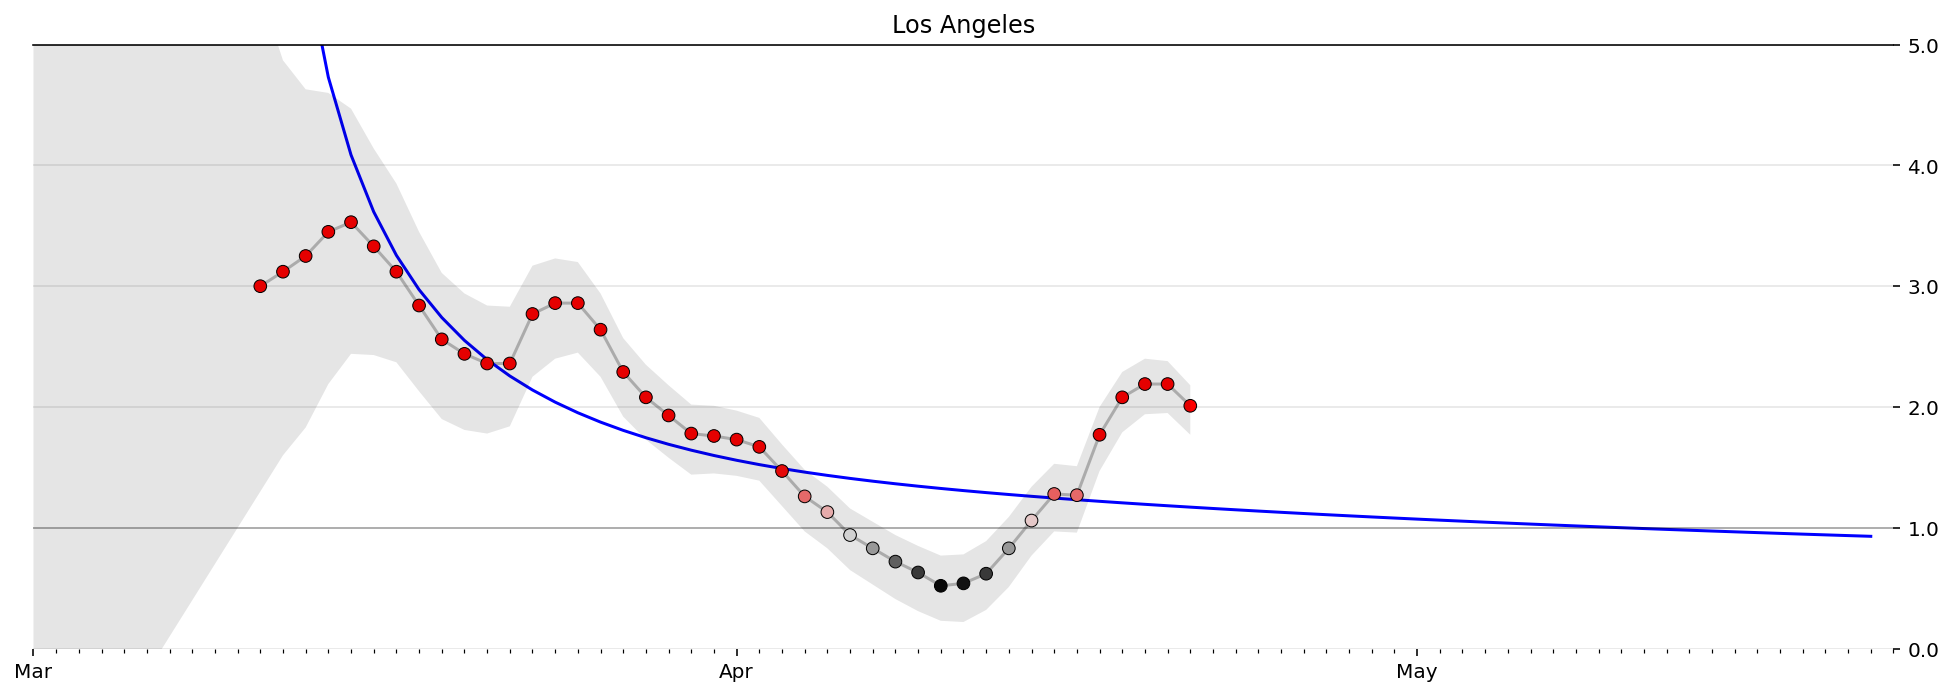

In [270]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1200/72,400/72))
fig.set_facecolor('w')

plot_rt_fc(sir_df, axes, county)

In [275]:
plot_actuals_sir(sir_df, county)

alt.LayerChart(...)

### Scratch

In [160]:
means = np.arange(5)
points = np.arange(-10, 10)
probs = sps.norm(loc=means, scale=5).pdf(points[:, None])#.pdf(np.array([1, 2, 3, 4, 5])[:, None])

In [222]:
sir_df.smoothed.loc[sir_df.ML.last_valid_index()]

1075.0

In [161]:
probs

array([[0.01079819, 0.00709492, 0.00447891, 0.00271659, 0.00158309],
       [0.01579003, 0.01079819, 0.00709492, 0.00447891, 0.00271659],
       [0.02218417, 0.01579003, 0.01079819, 0.00709492, 0.00447891],
       [0.02994549, 0.02218417, 0.01579003, 0.01079819, 0.00709492],
       [0.03883721, 0.02994549, 0.02218417, 0.01579003, 0.01079819],
       [0.04839414, 0.03883721, 0.02994549, 0.02218417, 0.01579003],
       [0.05793831, 0.04839414, 0.03883721, 0.02994549, 0.02218417],
       [0.06664492, 0.05793831, 0.04839414, 0.03883721, 0.02994549],
       [0.07365403, 0.06664492, 0.05793831, 0.04839414, 0.03883721],
       [0.07820854, 0.07365403, 0.06664492, 0.05793831, 0.04839414],
       [0.07978846, 0.07820854, 0.07365403, 0.06664492, 0.05793831],
       [0.07820854, 0.07978846, 0.07820854, 0.07365403, 0.06664492],
       [0.07365403, 0.07820854, 0.07978846, 0.07820854, 0.07365403],
       [0.06664492, 0.07365403, 0.07820854, 0.07978846, 0.07820854],
       [0.05793831, 0.06664492, 0.

In [162]:
probs.shape

(20, 5)

In [163]:
normalized = probs / np.sum(probs, axis=0)

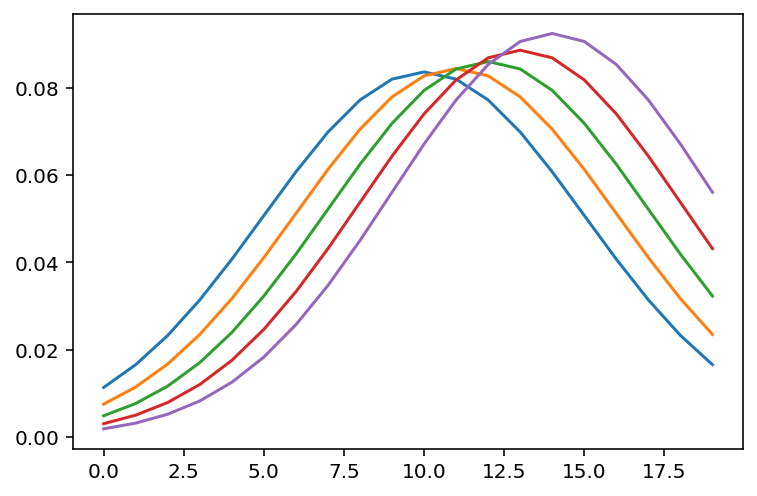

In [164]:
plt.plot(np.arange(probs.shape[0]), normalized)